# House Price Predictor

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import TensorDataset, DataLoader

In [3]:
# -----------------------------
# 1. Load the dataset
# -----------------------------
# Replace 'house_prices.csv' with the path to your dataset.
data = pd.read_csv('train.csv')
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,50,RL,51.0,4712,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,8,2006,WD,Abnorml,121600
996,997,20,RL,NaN,10659,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2006,COD,Normal,136500
997,998,20,RL,NaN,11717,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2009,WD,Normal,185000
998,999,30,RM,60.0,9786,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2006,WD,Normal,91000


In [4]:
# -----------------------------
# 2. Data Cleaning
# -----------------------------
# Select only numeric columns that have no missing data.
numeric_cols = data.select_dtypes(include=[np.number]).columns
clean_numeric_cols = [col for col in numeric_cols if data[col].isna().sum() == 0]
data_clean = data[clean_numeric_cols]

# Ensure that the target column 'price' is present.
if 'SalePrice' not in data_clean.columns:
    raise ValueError("The target column 'price' is not present in the complete numeric data.")

In [107]:
NVAR = 5

# -----------------------------
# 3. Feature Selection
# -----------------------------
# Compute the correlation matrix using only the cleaned numeric data.
corr_matrix = data_clean.corr()

# Compute absolute correlations of features with the target and drop the target itself.
target_corr = corr_matrix['SalePrice'].drop('SalePrice').abs().sort_values(ascending=False)
# print(target_corr)

# Select only the top NVAR features with the highest correlation with 'SalesPrice'
top_features = target_corr.head(NVAR).index
print(f"Selected top {NVAR} features:", list(top_features))

# Define input features (X) and target variable (y).
X = data_clean[top_features].values
y = data_clean['SalePrice'].values.reshape(-1, 1)

# -----------------------------
# 4. Data Preprocessing
# -----------------------------
# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features to improve training stability.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the numpy arrays to PyTorch tensors.
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create a TensorDataset and DataLoader for batch processing.
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# -----------------------------
# 5. Define the Neural Network Model
# -----------------------------
class HousePriceModel(nn.Module):
    def __init__(self, input_dim):
        super(HousePriceModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  # Output layer for regression
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HousePriceModel(input_dim=X_train.shape[1]).to(device)

# -----------------------------
# 6. Set Up Loss Function and Optimizer
# -----------------------------
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# -----------------------------
# 7. Train the Model
# -----------------------------
num_epochs = 2000
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch_X.size(0)
    
    epoch_loss = running_loss / len(train_dataset)
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# -----------------------------
# 8. Evaluate the Model
# -----------------------------
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor.to(device))
    test_loss = criterion(predictions, y_test_tensor.to(device)).item()
    print("Test Mean Squared Error:", test_loss)

print("")

# Optionally, to evaluate using scikit-learn's MSE:
predictions_np = predictions.cpu().numpy()
mse = mean_squared_error(y_test, predictions_np)
print("Test MSE (scikit-learn):", mse)
# Test Mean Squared Error: 935741376.0

# Calculate in-sample R^2 value
y_train_pred = model(X_train_tensor).detach().numpy()
ss_total = np.sum((y_train - np.mean(y_train))**2)
ss_residual = np.sum((y_train - y_train_pred)**2)
r2_score = 1 - (ss_residual / ss_total)
print(f'In-sample R^2: {r2_score:.4f}')

# Calculate out-of-sample R^2 value
y_test_pred = model(X_test_tensor).detach().numpy()
ss_total_test = np.sum((y_test - np.mean(y_test))**2)
ss_residual_test = np.sum((y_test - y_test_pred)**2)
r2_score_test = 1 - (ss_residual_test / ss_total_test)
print(f'Out-of-sample R^2: {r2_score_test:.4f}')

Selected top 5 features: ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF']
Epoch [100/2000], Loss: 7386752081.9200
Epoch [200/2000], Loss: 3133550177.2800
Epoch [300/2000], Loss: 1489642284.8000
Epoch [400/2000], Loss: 1330615632.6400
Epoch [500/2000], Loss: 1285745509.1200
Epoch [600/2000], Loss: 1258883957.7600
Epoch [700/2000], Loss: 1241085539.8400
Epoch [800/2000], Loss: 1229159741.4400
Epoch [900/2000], Loss: 1220857146.8800
Epoch [1000/2000], Loss: 1217095535.3600
Epoch [1100/2000], Loss: 1211245048.3200
Epoch [1200/2000], Loss: 1208739080.9600
Epoch [1300/2000], Loss: 1204897529.6000
Epoch [1400/2000], Loss: 1202925579.5200
Epoch [1500/2000], Loss: 1200789841.9200
Epoch [1600/2000], Loss: 1199190416.6400
Epoch [1700/2000], Loss: 1198596357.1200
Epoch [1800/2000], Loss: 1197158551.0400
Epoch [1900/2000], Loss: 1195143073.2800
Epoch [2000/2000], Loss: 1193230533.1200
Test Mean Squared Error: 867080512.0

Test MSE (scikit-learn): 867080565.7001562
In-sample R

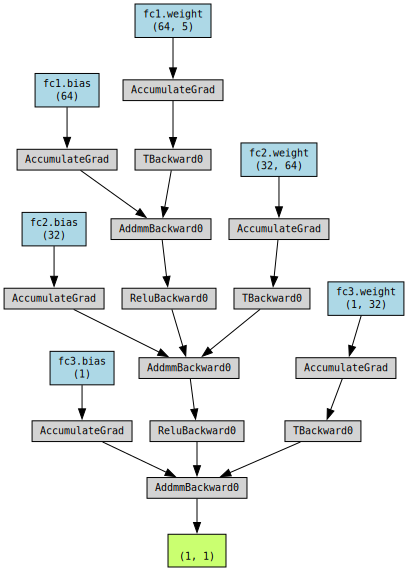

In [108]:
#Visualize the neural net (for reference)
from torchviz import make_dot
x=torch.randn(1, X_train.shape[1])
y=model(x)
make_dot(y, params=dict(model.named_parameters()))

In [143]:
# -----------------------------
# X. Load the test data and predict/write to predictions.csv
# -----------------------------
data_testset = pd.read_csv('test.csv')

X_testset = data_testset[top_features].values
X_testset = scaler.transform(X_testset)
X_testset_tensor = torch.tensor(X_testset, dtype=torch.float32)

y_testset_pred = model(X_testset_tensor).detach().numpy()
data_testset["SALEPRICE"] = y_testset_pred
data_testset["ID"] = data_testset["Id"]
print(data_testset.loc[:,['ID', 'SALEPRICE']])
data_testset.to_csv("predictions.csv", columns=['ID', 'SALEPRICE'], header=True, index=False)

       ID      SALEPRICE
0    1001   86286.765625
1    1002  100186.929688
2    1003  283795.843750
3    1004  180782.062500
4    1005  203483.921875
..    ...            ...
455  1456  173759.140625
456  1457  219339.828125
457  1458  221575.015625
458  1459  123106.023438
459  1460  134942.234375

[460 rows x 2 columns]


In [89]:
# Used to find the seemingly best number of independent variables => Best out-of-sample R^2 at NVAR=5
def iterateOverNvar(minN, maxN)
    for NVAR in range(minN,maxN+1):
        # -----------------------------
        # 3. Feature Selection
        # -----------------------------
        # Compute the correlation matrix using only the cleaned numeric data.
        corr_matrix = data_clean.corr()
        
        # Compute absolute correlations of features with the target and drop the target itself.
        target_corr = corr_matrix['SalePrice'].drop('SalePrice').abs().sort_values(ascending=False)
        # target_corr = corr_matrix['SalePrice'].drop('SalePrice').drop("GarageArea").abs().sort_values(ascending=False)
        # print(target_corr)
        
        # Select only the top NVAR features with the highest correlation with 'SalesPrice'
        top_features = target_corr.head(NVAR).index
        print(f"Selected top {NVAR} features:", list(top_features))
        
        # Define input features (X) and target variable (y).
        X = data_clean[top_features].values
        y = data_clean['SalePrice'].values.reshape(-1, 1)
        
        # -----------------------------
        # 4. Data Preprocessing
        # -----------------------------
        # Split the data into training and testing sets.
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Standardize features to improve training stability.
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Convert the numpy arrays to PyTorch tensors.
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
        
        # Create a TensorDataset and DataLoader for batch processing.
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        
        # -----------------------------
        # 5. Define the Neural Network Model
        # -----------------------------
        class HousePriceModel(nn.Module):
            def __init__(self, input_dim):
                super(HousePriceModel, self).__init__()
                self.fc1 = nn.Linear(input_dim, 64)
                self.fc2 = nn.Linear(64, 32)
                self.fc3 = nn.Linear(32, 1)  # Output layer for regression
                self.relu = nn.ReLU()
            
            def forward(self, x):
                x = self.relu(self.fc1(x))
                x = self.relu(self.fc2(x))
                x = self.fc3(x)
                return x
        
        # Use GPU if available
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = HousePriceModel(input_dim=X_train.shape[1]).to(device)
        
        # -----------------------------
        # 6. Set Up Loss Function and Optimizer
        # -----------------------------
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # -----------------------------
        # 7. Train the Model
        # -----------------------------
        num_epochs = 1000
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item() * batch_X.size(0)
            
            epoch_loss = running_loss / len(train_dataset)
            if (epoch + 1) % 100 == 0:
                pass
                # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        
        # -----------------------------
        # 8. Evaluate the Model
        # -----------------------------
        model.eval()
        with torch.no_grad():
            predictions = model(X_test_tensor.to(device))
            test_loss = criterion(predictions, y_test_tensor.to(device)).item()
            print("Test Mean Squared Error:", test_loss)
            
        # Optionally, to evaluate using scikit-learn's MSE:
        predictions_np = predictions.cpu().numpy()
        mse = mean_squared_error(y_test, predictions_np)
        print("Test MSE (scikit-learn):", mse)
        # Test Mean Squared Error: 935741376.0
        
        # Calculate in-sample R^2 value
        y_train_pred = model(X_train_tensor).detach().numpy()
        ss_total = np.sum((y_train - np.mean(y_train))**2)
        ss_residual = np.sum((y_train - y_train_pred)**2)
        r2_score = 1 - (ss_residual / ss_total)
        print(f'In-sample R^2: {r2_score:.4f}')
        
        # Calculate out-of-sample R^2 value
        y_test_pred = model(X_test_tensor).detach().numpy()
        ss_total_test = np.sum((y_test - np.mean(y_test))**2)
        ss_residual_test = np.sum((y_test - y_test_pred)**2)
        r2_score_test = 1 - (ss_residual_test / ss_total_test)
        print(f'Out-of-sample R^2: {r2_score_test:.4f}')
        print("")

Selected top 1 features: ['OverallQual']
Test Mean Squared Error: 1396494848.0
Test MSE (scikit-learn): 1396494633.746641
In-sample R^2: 0.6868
Out-of-sample R^2: 0.6656

Selected top 2 features: ['OverallQual', 'GrLivArea']
Test Mean Squared Error: 1079591296.0
Test MSE (scikit-learn): 1079591304.9249659
In-sample R^2: 0.7780
Out-of-sample R^2: 0.7415

Selected top 3 features: ['OverallQual', 'GrLivArea', 'GarageCars']
Test Mean Squared Error: 902517376.0
Test MSE (scikit-learn): 902517316.6596829
In-sample R^2: 0.7974
Out-of-sample R^2: 0.7839

Selected top 4 features: ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea']
Test Mean Squared Error: 921514048.0
Test MSE (scikit-learn): 921514014.3214035
In-sample R^2: 0.8041
Out-of-sample R^2: 0.7793

Selected top 5 features: ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF']
Test Mean Squared Error: 893399040.0
Test MSE (scikit-learn): 893399035.6906488
In-sample R^2: 0.8276
Out-of-sample R^2: 0.7861

Selected t